# Informer 训练前后对比 - Notebook 版

**适用于阿里云天池 / Jupyter Notebook 环境**

本 Notebook 将演示如何：
1. ✅ 准备环境和数据
2. ✅ 评估训练前的模型（随机初始化基线）
3. ✅ 训练 Informer 模型
4. ✅ 评估训练后的模型
5. ✅ 生成可视化对比

---

## 📋 步骤 1：环境检查与配置

首先检查运行环境，确认 GPU 可用性

In [1]:
import os
import sys

# 检查当前目录
current_dir = os.getcwd()
print(f"当前工作目录: {current_dir}")

# 如果当前目录不是 Informer2020，尝试切换
if not os.path.exists('exp/exp_informer.py'):
    print("\n⚠️ 检测到不在项目根目录，尝试自动定位...")

    # 方法1：检查是否在 Informer2020 的子目录
    if 'Informer2020' in current_dir:
        # 向上查找到 Informer2020 目录
        parts = current_dir.split(os.sep)
        try:
            idx = parts.index('Informer2020')
            project_root = os.sep.join(parts[:idx+1])
            os.chdir(project_root)
            print(f"✅ 已切换到项目目录: {project_root}")
        except ValueError:
            pass

    # 方法2：检查同级或上级目录
    if not os.path.exists('exp/exp_informer.py'):
        for candidate in ['./Informer2020', '../Informer2020', '../../Informer2020']:
            if os.path.exists(candidate + '/exp/exp_informer.py'):
                os.chdir(candidate)
                print(f"✅ 已切换到项目目录: {os.getcwd()}")
                break

    # 方法3：手动指定（天池环境常见路径）
    if not os.path.exists('exp/exp_informer.py'):
        common_paths = [
            '/home/tianchi/Informer2020',
            '/mnt/workspace/Informer2020',
            os.path.expanduser('~/Informer2020')
        ]
        for path in common_paths:
            if os.path.exists(path + '/exp/exp_informer.py'):
                os.chdir(path)
                print(f"✅ 已切换到项目目录: {path}")
                break

# 最终验证
if os.path.exists('exp/exp_informer.py'):
    print("\n✅ 项目目录设置成功！")
    print(f"   工作目录: {os.getcwd()}")

    # 添加到 Python 路径（确保导入正常）
    if os.getcwd() not in sys.path:
        sys.path.insert(0, os.getcwd())
        print(f"   已添加到 Python 路径")
else:
    print("\n❌ 错误：无法找到 Informer2020 项目目录！")
    print("\n请手动执行以下操作之一：")
    print("1. 将此 Notebook 上传到 Informer2020 目录下")
    print("2. 在天池中克隆项目：")
    print("   !git clone https://github.com/zhouhaoyi/Informer2020.git")
    print("   然后将 Notebook 移动到 Informer2020 目录下重新运行")
    print("3. 或在下一个 cell 手动执行：")
    print("   import os; os.chdir('/你的/Informer2020/路径')")

当前工作目录: /content

⚠️ 检测到不在项目根目录，尝试自动定位...
✅ 已切换到项目目录: /content/Informer2020

✅ 项目目录设置成功！
   工作目录: /content/Informer2020
   已添加到 Python 路径


In [2]:
 !git clone https://github.com/zhouhaoyi/Informer2020.git

fatal: destination path 'Informer2020' already exists and is not an empty directory.


In [3]:
 import os; os.chdir('/content/Informer2020')

In [4]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
import warnings
warnings.filterwarnings('ignore')

# NumPy 2.0 兼容性修复
import numpy as np
np_version = np.__version__
if int(np_version.split('.')[0]) >= 2:
    print(f"⚠️  检测到 NumPy {np_version}（2.0+），应用兼容性修复...")
    # 临时兼容：如果代码使用了旧的 np.Inf，自动修复
    if not hasattr(np, 'Inf'):
        np.Inf = np.inf
        np.NaN = np.nan
        np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
        np.PINF = np.PINF if hasattr(np, 'PINF') else np.inf
    print("✅ NumPy 2.0 兼容性修复已应用")

# 设置 matplotlib 中文显示（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 打印环境信息
print("="*60)
print("🔍 环境检查")
print("="*60)
print(f"Python 版本: {sys.version.split()[0]}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 版本: {torch.version.cuda}")
print(f"当前工作目录: {os.getcwd()}")
print("="*60)

⚠️  检测到 NumPy 2.0.2（2.0+），应用兼容性修复...
✅ NumPy 2.0 兼容性修复已应用
🔍 环境检查
Python 版本: 3.12.12
PyTorch 版本: 2.8.0+cu126
CUDA 可用: True
GPU 设备: Tesla T4
CUDA 版本: 12.6
当前工作目录: /content/Informer2020


## 📊 步骤 2：下载并准备数据

天池环境通常有外网访问权限，可以直接下载数据

In [5]:
# 创建数据目录
!mkdir -p data/ETT

# 下载 ETTh1 数据集（约 2MB）
print("📥 正在下载 ETTh1 数据集...")
!wget -q --show-progress https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv -O data/ETT/ETTh1.csv

# 验证下载
import os.path as osp
data_path = 'data/ETT/ETTh1.csv'
if osp.exists(data_path):
    file_size = osp.getsize(data_path) / (1024 * 1024)
    print(f"✅ 下载成功！文件大小: {file_size:.2f} MB")

    # 预览数据
    df = pd.read_csv(data_path)
    print(f"\n数据维度: {df.shape}")
    print(f"列名: {list(df.columns)}")
    print("\n前 3 行数据:")
    display(df.head(3))
else:
    print("❌ 下载失败，请检查网络连接")

📥 正在下载 ETTh1 数据集...
data/ETT/ETTh1.csv  100%[===================>]   2.47M  --.-KB/s    in 0.04s   
✅ 下载成功！文件大小: 2.47 MB

数据维度: (17420, 8)
列名: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

前 3 行数据:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001


## ⚙️ 步骤 3：配置实验参数

可以根据需要修改这些参数

In [6]:
# ============ 实验配置（可修改） ============

class Config:
    # 基础参数
    model = 'informer'
    data = 'ETTh1'
    root_path = './data/ETT/'
    data_path = 'ETTh1.csv'
    features = 'M'  # M: 多变量, S: 单变量, MS: 多变量预测单变量
    target = 'OT'
    freq = 'h'
    checkpoints = './checkpoints/'

    # 序列参数
    seq_len = 96      # 输入序列长度
    label_len = 48    # decoder 起始长度
    pred_len = 24     # 预测长度（可选: 24, 48, 96, 192, 720）

    # 模型参数
    enc_in = 7
    dec_in = 7
    c_out = 7
    d_model = 512     # 模型维度（显存不足可改为 256）
    n_heads = 8
    e_layers = 2
    d_layers = 1
    s_layers = [3, 2, 1]
    d_ff = 2048       # FFN 维度（显存不足可改为 1024）
    factor = 5
    padding = 0
    distil = True
    dropout = 0.05
    attn = 'prob'     # 'prob' 或 'full'
    embed = 'timeF'
    activation = 'gelu'
    output_attention = False
    do_predict = False
    mix = True
    cols = None

    # 训练参数（天池环境建议调小）
    num_workers = 0
    itr = 1           # 实验次数
    train_epochs = 20  # 训练轮数（快速演示用 3，完整实验用 10）
    batch_size = 32   # 批次大小（显存不足改为 16）
    patience = 7
    learning_rate = 0.0001
    des = 'notebook_exp'
    loss = 'mse'
    lradj = 'type1'
    use_amp = False   # 混合精度训练（有 GPU 可开启）
    inverse = False

    # GPU 设置
    use_gpu = torch.cuda.is_available()
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    device_ids = [0]

    # 自动设置
    detail_freq = freq
    freq = freq[-1:]

args = Config()

# 打印配置
print("="*60)
print("📝 实验配置")
print("="*60)
print(f"数据集: {args.data}")
print(f"任务类型: {args.features}")
print(f"序列长度: 输入={args.seq_len}, 预测={args.pred_len}")
print(f"模型: d_model={args.d_model}, d_ff={args.d_ff}")
print(f"训练: epochs={args.train_epochs}, batch_size={args.batch_size}")
print(f"设备: {'GPU' if args.use_gpu else 'CPU'}")
print("="*60)

📝 实验配置
数据集: ETTh1
任务类型: M
序列长度: 输入=96, 预测=24
模型: d_model=512, d_ff=2048
训练: epochs=20, batch_size=32
设备: GPU


## 🏗️ 步骤 4：初始化模型和实验

导入必要的模块并创建实验对象

In [7]:
# 导入实验类
from exp.exp_informer import Exp_Informer
from utils.metrics import metric

# 创建实验设置字符串
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
    args.model, args.data, args.features,
    args.seq_len, args.label_len, args.pred_len,
    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
    args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

print(f"实验 ID: {setting}")

# 初始化实验
print("\n🔧 正在初始化模型...")
exp = Exp_Informer(args)
print("✅ 模型初始化完成！")

# 打印模型参数量
total_params = sum(p.numel() for p in exp.model.parameters())
trainable_params = sum(p.numel() for p in exp.model.parameters() if p.requires_grad)
print(f"\n模型参数量: {total_params:,} (可训练: {trainable_params:,})")

实验 ID: informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_notebook_exp

🔧 正在初始化模型...
Use GPU: cuda:0
✅ 模型初始化完成！

模型参数量: 11,330,055 (可训练: 11,330,055)


## 📊 步骤 5：训练前评估（基线）

评估随机初始化的模型性能

In [8]:
def evaluate_model(exp, setting, save_prefix='', verbose=True):
    """评估模型并返回指标"""
    if verbose:
        print(f"\n{'='*60}")
        print(f"📈 评估: {save_prefix}")
        print("="*60)

    test_data, test_loader = exp._get_data(flag='test')
    exp.model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            pred, true = exp._process_one_batch(
                test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())
            trues.append(true.detach().cpu().numpy())

            # 进度条（每 20%）
            if verbose and (i + 1) % max(1, len(test_loader) // 5) == 0:
                progress = (i + 1) / len(test_loader) * 100
                print(f"  进度: {progress:.0f}%")

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    # 计算指标
    mae, mse, rmse, mape, mspe = metric(preds, trues)

    if verbose:
        print(f"\n📊 {save_prefix} 指标:")
        print(f"  MAE:  {mae:.6f}")
        print(f"  MSE:  {mse:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAPE: {mape:.6f}")
        print(f"  MSPE: {mspe:.6f}")

    # 保存结果
    folder_path = './results/' + setting + '/'
    os.makedirs(folder_path, exist_ok=True)

    np.save(folder_path + f'{save_prefix}_metrics.npy',
            np.array([mae, mse, rmse, mape, mspe]))
    np.save(folder_path + f'{save_prefix}_pred.npy', preds)
    np.save(folder_path + f'{save_prefix}_true.npy', trues)

    return np.array([mae, mse, rmse, mape, mspe]), preds, trues

# 评估训练前
before_metrics, before_preds, before_trues = evaluate_model(exp, setting, 'before')


📈 评估: before
test 2857
  进度: 19%
  进度: 38%
  进度: 57%
  进度: 76%
  进度: 96%

📊 before 指标:
  MAE:  0.842754
  MSE:  1.243111
  RMSE: 1.114949
  MAPE: 15.667580
  MSPE: 83635.156250


## 🚀 步骤 6：训练模型

开始训练（可能需要几分钟到几十分钟）

In [9]:
print("\n" + "="*60)
print("🏋️ 开始训练")
print("="*60)

# 训练模型
exp.train(setting)

print("\n✅ 训练完成！")


🏋️ 开始训练
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.3550107
	speed: 0.0931s/iter; left time: 486.0860s
	iters: 200, epoch: 1 | loss: 0.3025309
	speed: 0.0809s/iter; left time: 414.4633s
Epoch: 1 cost time: 21.46525287628174
Epoch: 1, Steps: 266 | Train Loss: 0.4126922 Vali Loss: 0.7263428 Test Loss: 0.5498629
Validation loss decreased (inf --> 0.726343).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.3165154
	speed: 0.1848s/iter; left time: 915.6279s
	iters: 200, epoch: 2 | loss: 0.2299166
	speed: 0.0770s/iter; left time: 374.0600s
Epoch: 2 cost time: 20.59504246711731
Epoch: 2, Steps: 266 | Train Loss: 0.2558530 Vali Loss: 0.6288804 Test Loss: 0.5644326
Validation loss decreased (0.726343 --> 0.628880).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.1815461
	speed: 0.1804s/iter; left time: 846.0140s
	iters: 200, epoch: 3 | loss: 0.1869704
	speed: 0.0797s/iter; left time: 365.9375s
Epoch: 3 cost t

## 📈 步骤 7：训练后评估

评估训练后的模型性能

In [10]:
# 评估训练后
after_metrics, after_preds, after_trues = evaluate_model(exp, setting, 'after')


📈 评估: after
test 2857
  进度: 19%
  进度: 38%
  进度: 57%
  进度: 76%
  进度: 96%

📊 after 指标:
  MAE:  0.557676
  MSE:  0.564146
  RMSE: 0.751096
  MAPE: 10.306871
  MSPE: 38109.968750


## 📊 步骤 8：生成对比可视化

生成漂亮的对比图表

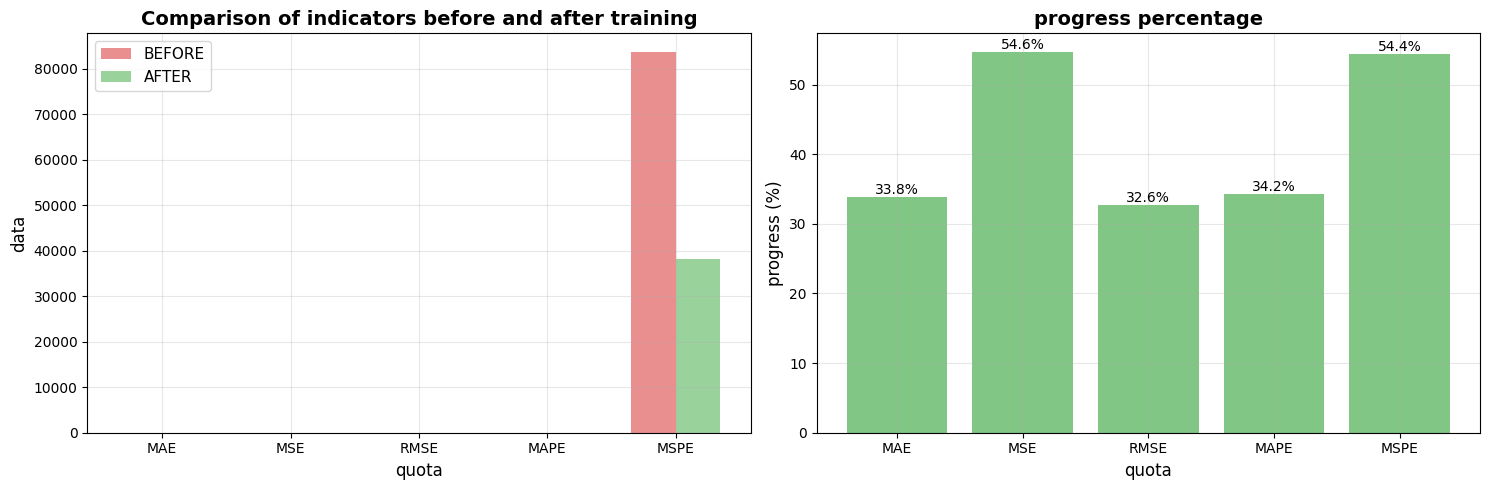

✅ 指标对比图已保存


In [11]:
# 1. 指标对比柱状图
metrics_names = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MSPE']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左图：指标对比
x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, before_metrics, width, label='BEFORE', alpha=0.8, color='#E57373')
axes[0].bar(x + width/2, after_metrics, width, label='AFTER', alpha=0.8, color='#81C784')
axes[0].set_xlabel('quota', fontsize=12)
axes[0].set_ylabel('data', fontsize=12)
axes[0].set_title('Comparison of indicators before and after training', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：改进百分比
improvement = np.zeros_like(before_metrics)
for i in range(len(before_metrics)):
    if abs(before_metrics[i]) > 1e-10:
        improvement[i] = ((before_metrics[i] - after_metrics[i]) / before_metrics[i]) * 100
    else:
        improvement[i] = 0

colors = ['#4CAF50' if imp > 0 else '#F44336' for imp in improvement]
axes[1].bar(x, improvement, color=colors, alpha=0.7)
axes[1].set_xlabel('quota', fontsize=12)
axes[1].set_ylabel('progress (%)', fontsize=12)
axes[1].set_title('progress percentage', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# 添加数值标签
for i, imp in enumerate(improvement):
    axes[1].text(i, imp, f'{imp:.1f}%', ha='center',
                va='bottom' if imp > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig(f'./results/{setting}/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 指标对比图已保存")

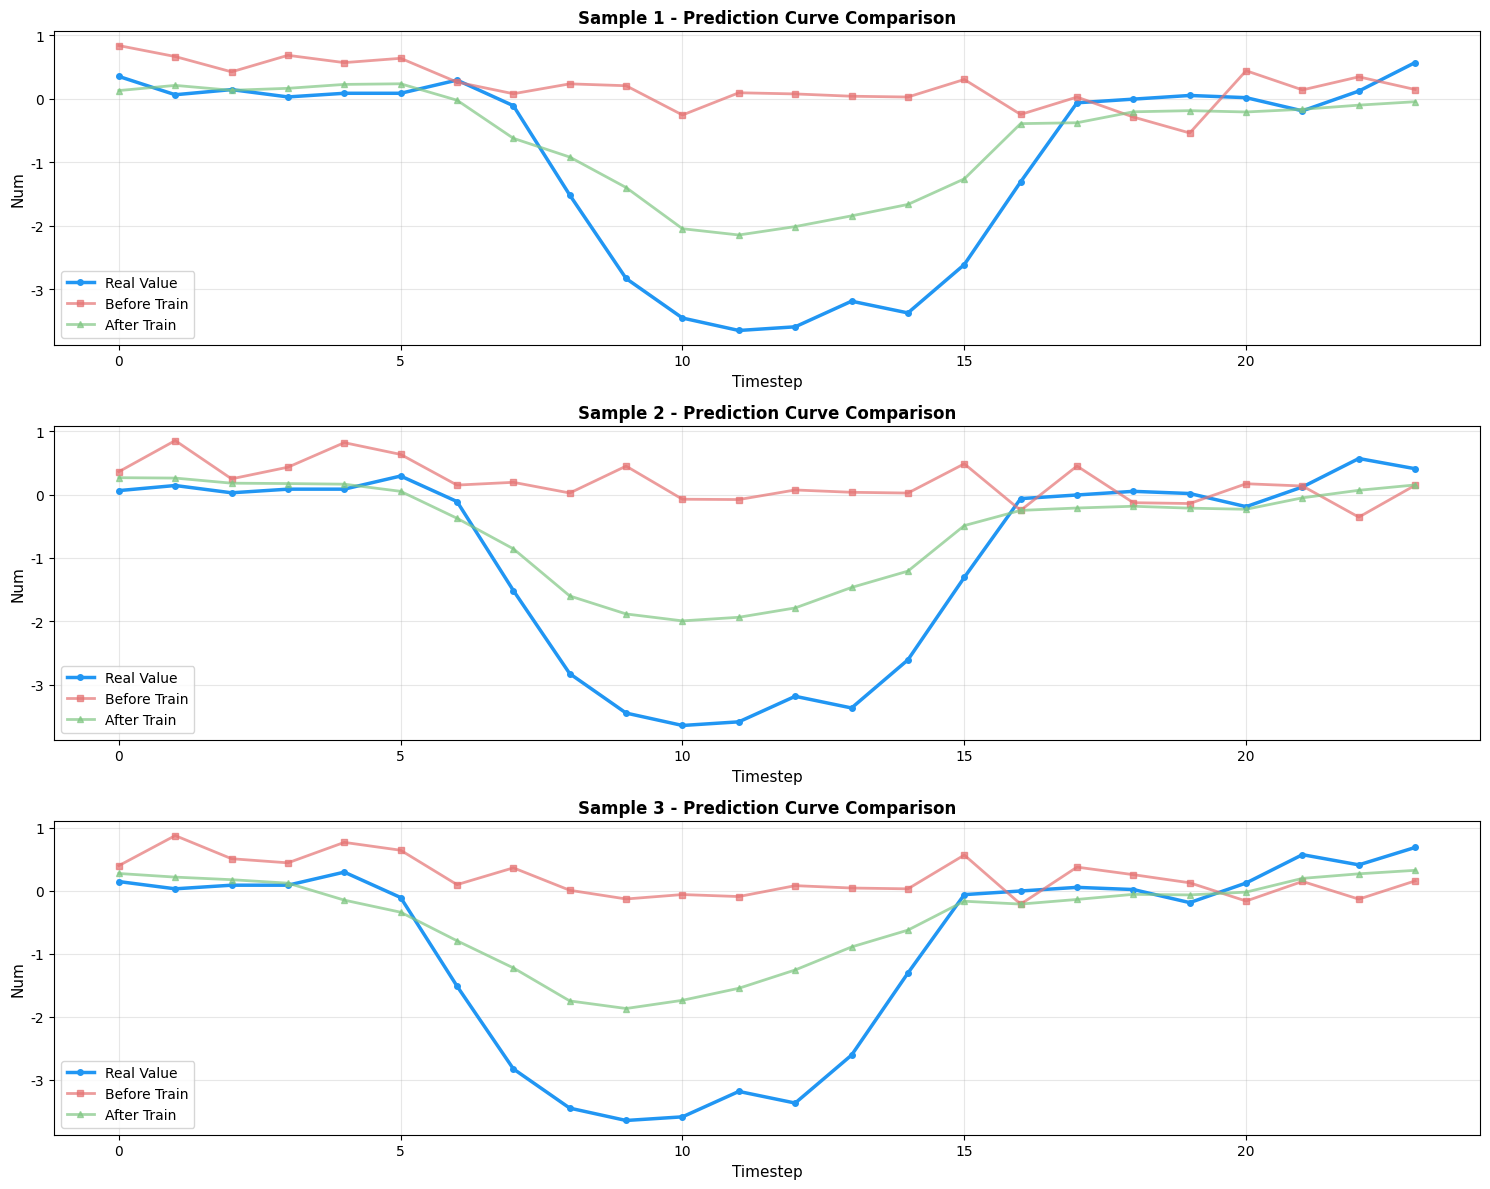

✅ 预测曲线对比图已保存


In [12]:
# 2. 预测曲线对比（展示 3 个样本）
num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
if num_samples == 1:
    axes = [axes]

for i in range(num_samples):
    ax = axes[i]
    x_axis = np.arange(before_preds.shape[1])

    # 只展示第一个特征维度
    ax.plot(x_axis, before_trues[i, :, 0], label='Real Value',
            linewidth=2.5, marker='o', markersize=4, color='#2196F3')
    ax.plot(x_axis, before_preds[i, :, 0], label='Before Train',
            linewidth=2, marker='s', markersize=4, alpha=0.7, color='#E57373')
    ax.plot(x_axis, after_preds[i, :, 0], label='After Train',
            linewidth=2, marker='^', markersize=4, alpha=0.7, color='#81C784')

    ax.set_xlabel('Timestep', fontsize=11)
    ax.set_ylabel('Num', fontsize=11)
    ax.set_title(f'Sample {i+1} - Prediction Curve Comparison', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 预测曲线对比图已保存")

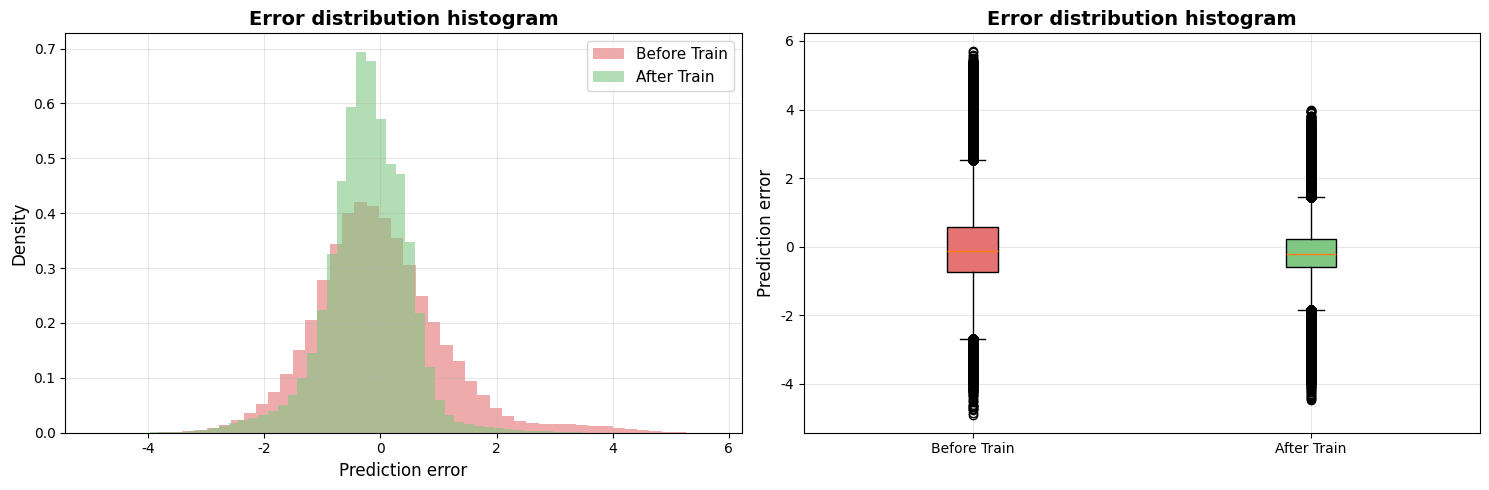

✅ 误差分布图已保存


In [13]:
# 3. 误差分布对比
before_errors = (before_preds - before_trues).flatten()
after_errors = (after_preds - after_trues).flatten()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左图：直方图
axes[0].hist(before_errors, bins=50, alpha=0.6, label='Before Train',
            density=True, color='#E57373')
axes[0].hist(after_errors, bins=50, alpha=0.6, label='After Train',
            density=True, color='#81C784')
axes[0].set_xlabel('Prediction error', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Error distribution histogram', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 右图：箱线图
bp = axes[1].boxplot([before_errors, after_errors],
                     labels=['Before Train', 'After Train'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('#E57373')
bp['boxes'][1].set_facecolor('#81C784')
axes[1].set_ylabel('Prediction error', fontsize=12)
axes[1].set_title('Error distribution histogram', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./results/{setting}/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 误差分布图已保存")

## 📝 步骤 9：生成文本报告

In [14]:
# 计算改进百分比
improvement = np.zeros(len(before_metrics))
for i in range(len(before_metrics)):
    if abs(before_metrics[i]) > 1e-10:
        improvement[i] = ((before_metrics[i] - after_metrics[i]) / before_metrics[i]) * 100

# 生成 HTML 报告
report_html = f"""
<div style="font-family: Arial; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h2 style="color: #333;">📊 训练对比报告</h2>
    <hr>

    <h3>实验配置</h3>
    <ul>
        <li><b>数据集:</b> {args.data}</li>
        <li><b>序列长度:</b> 输入={args.seq_len}, 预测={args.pred_len}</li>
        <li><b>训练轮数:</b> {args.train_epochs}</li>
        <li><b>设备:</b> {'GPU' if args.use_gpu else 'CPU'}</li>
    </ul>

    <h3>训练前指标（基线）</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #E57373; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">数值</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right;">{before_metrics[0]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right;">{before_metrics[1]:.6f}</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right;">{before_metrics[2]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right;">{before_metrics[3]:.6f}</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right;">{before_metrics[4]:.6f}</td></tr>
    </table>

    <h3>训练后指标</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #81C784; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">数值</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right;">{after_metrics[0]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right;">{after_metrics[1]:.6f}</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right;">{after_metrics[2]:.6f}</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right;">{after_metrics[3]:.6f}</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right;">{after_metrics[4]:.6f}</td></tr>
    </table>

    <h3>性能改进</h3>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background-color: #4CAF50; color: white;">
            <th style="padding: 10px; text-align: left;">指标</th>
            <th style="padding: 10px; text-align: right;">改进百分比</th>
        </tr>
        <tr><td style="padding: 8px;">MAE</td><td style="padding: 8px; text-align: right; color: {'green' if improvement[0]>0 else 'red'}; font-weight: bold;">{improvement[0]:+.2f}%</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MSE</td><td style="padding: 8px; text-align: right; color: {'green' if improvement[1]>0 else 'red'}; font-weight: bold;">{improvement[1]:+.2f}%</td></tr>
        <tr><td style="padding: 8px;">RMSE</td><td style="padding: 8px; text-align: right; color: {'green' if improvement[2]>0 else 'red'}; font-weight: bold;">{improvement[2]:+.2f}%</td></tr>
        <tr style="background-color: #fafafa;"><td style="padding: 8px;">MAPE</td><td style="padding: 8px; text-align: right; color: {'green' if improvement[3]>0 else 'red'}; font-weight: bold;">{improvement[3]:+.2f}%</td></tr>
        <tr><td style="padding: 8px;">MSPE</td><td style="padding: 8px; text-align: right; color: {'green' if improvement[4]>0 else 'red'}; font-weight: bold;">{improvement[4]:+.2f}%</td></tr>
    </table>

    <p style="margin-top: 20px; color: #666; font-size: 12px;">所有结果已保存到: ./results/{setting}/</p>
</div>
"""

display(HTML(report_html))

# 保存文本版本
with open(f'./results/{setting}/comparison_report.txt', 'w') as f:
    f.write('='*60 + '\n')
    f.write('训练对比报告\n')
    f.write('='*60 + '\n\n')
    f.write(f'实验 ID: {setting}\n\n')
    f.write('训练前指标:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {before_metrics[i]:.6f}\n')
    f.write('\n训练后指标:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {after_metrics[i]:.6f}\n')
    f.write('\n改进百分比:\n')
    for i, name in enumerate(metrics_names):
        f.write(f'  {name}: {improvement[i]:+.2f}%\n')

print("\n✅ 文本报告已保存")

指标,数值
MAE,0.842754
MSE,1.243111
RMSE,1.114949
MAPE,15.667580
MSPE,83635.156250
指标,数值
MAE,0.557676
MSE,0.564146
RMSE,0.751096
MAPE,10.306871



✅ 文本报告已保存


## 🎉 总结

实验完成！所有结果已保存到 `./results/` 目录。

### 下一步：
- 📊 查看生成的图表
- 🔧 调整参数（修改步骤 3 的配置）
- 📈 尝试不同的数据集或预测长度
- 💾 下载结果到本地分析